In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

print("=== LANGKAH 1: TUJUAN, METRIK, DAN BATASAN ===")

# Load processed data
df = pd.read_csv('processed_kelulusan.csv')
X = df.drop('Lulus', axis=1)
y = df['Lulus']

print(" Dataset Info:")
print(f"• Shape: {df.shape}")
print(f"• Kelas: {y.value_counts().to_dict()}")
print(f"• Persentase Kelulusan: {y.mean()*100:.1f}%")

# Tujuan dan Metrik
print("\n Tujuan & Metrik:")
print("• Tujuan: Prediksi kelulusan mahasiswa berdasarkan performa akademik")
print("• Metrik Utama: Accuracy (karena kelas seimbang)")
print("• Metrik Sekunder: F1-Score, ROC-AUC")
print("• Batasan: Waktu training < 2 menit, model size < 10MB")

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=1, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=2, random_state=42
)

print(f"Data Splits:")
print(f"• Train: {X_train.shape[0]} samples")
print(f"• Validation: {X_val.shape[0]} samples")
print(f"• Test: {X_test.shape[0]} samples")
print(f"Distribusi Train: {y_train.value_counts().to_dict()}")
print(f"Distribusi Val: {y_val.value_counts().to_dict()}")
print(f"Distribusi Test: {y_test.value_counts().to_dict()}")

=== LANGKAH 1: TUJUAN, METRIK, DAN BATASAN ===
 Dataset Info:
• Shape: (10, 12)
• Kelas: {1: 5, 0: 5}
• Persentase Kelulusan: 50.0%

 Tujuan & Metrik:
• Tujuan: Prediksi kelulusan mahasiswa berdasarkan performa akademik
• Metrik Utama: Accuracy (karena kelas seimbang)
• Metrik Sekunder: F1-Score, ROC-AUC
• Batasan: Waktu training < 2 menit, model size < 10MB
Data Splits:
• Train: 7 samples
• Validation: 2 samples
• Test: 1 samples
Distribusi Train: {1: 4, 0: 3}
Distribusi Val: {0: 2}
Distribusi Test: {1: 1}



=== LANGKAH 2: BASELINE MODEL ===
📈 Baseline Model Performance (Validation Set):
• Accuracy: 1.0000
• F1-Score: 0.0000
• ROC-AUC: nan

📋 Classification Report Baseline:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


🎯 Baseline CV Accuracy: 1.0000 (+/- 0.0000)


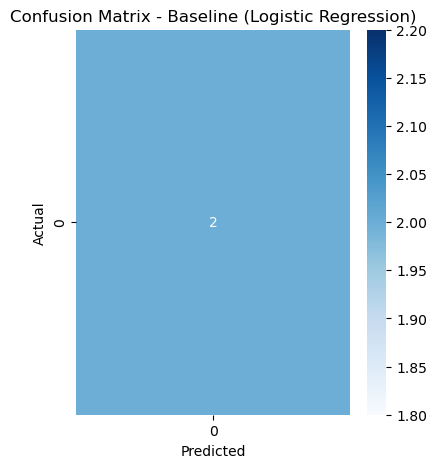

In [4]:
print("\n=== LANGKAH 2: BASELINE MODEL ===")

# Pipeline untuk baseline Logistic Regression
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

# Training baseline
baseline_pipeline.fit(X_train, y_train)

# Evaluasi baseline
y_pred_baseline = baseline_pipeline.predict(X_val)
y_pred_proba_baseline = baseline_pipeline.predict_proba(X_val)[:, 1]

accuracy_baseline = accuracy_score(y_val, y_pred_baseline)
f1_baseline = f1_score(y_val, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_val, y_pred_proba_baseline)

print("📈 Baseline Model Performance (Validation Set):")
print(f"• Accuracy: {accuracy_baseline:.4f}")
print(f"• F1-Score: {f1_baseline:.4f}")
print(f"• ROC-AUC: {roc_auc_baseline:.4f}")

print("\n📋 Classification Report Baseline:")
print(classification_report(y_val, y_pred_baseline))

# Confusion Matrix Baseline
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
cm_baseline = confusion_matrix(y_val, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Cross-validation untuk baseline
cv_scores_baseline = cross_val_score(baseline_pipeline, X_train, y_train, 
                                    cv=StratifiedKFold(n_splits=3), scoring='accuracy')
print(f"\n🎯 Baseline CV Accuracy: {cv_scores_baseline.mean():.4f} (+/- {cv_scores_baseline.std() * 2:.4f})")

In [5]:
print("\n=== LANGKAH 3: MODEL ALTERNATIF ===")

# Model 1: Random Forest dengan tuning
print("🤖 Training Random Forest...")
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning untuk Random Forest
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [3, 5, 7],
    'rf__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=StratifiedKFold(n_splits=3), 
                      scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(f"✅ Random Forest Best Params: {rf_grid.best_params_}")
print(f"✅ Random Forest Best CV Score: {rf_grid.best_score_:.4f}")

# Model 2: SVM dengan tuning
print("\n🤖 Training SVM...")
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42, probability=True))
])

# Hyperparameter tuning untuk SVM
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=StratifiedKFold(n_splits=3), 
                       scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print(f"✅ SVM Best Params: {svm_grid.best_params_}")
print(f"✅ SVM Best CV Score: {svm_grid.best_score_:.4f}")

# Evaluasi semua model di validation set
models = {
    'Baseline Logistic Regression': baseline_pipeline,
    'Random Forest': rf_grid.best_estimator_,
    'SVM': svm_grid.best_estimator_
}

validation_results = []

print("\n📊 VALIDATION SET PERFORMANCE COMPARISON:")
for name, model in models.items():
    if name == 'SVM':
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
    else:
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    validation_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

validation_df = pd.DataFrame(validation_results)
print(f"\n🏆 Best Model on Validation: {validation_df.loc[validation_df['Accuracy'].idxmax(), 'Model']}")


=== LANGKAH 3: MODEL ALTERNATIF ===
🤖 Training Random Forest...
✅ Random Forest Best Params: {'rf__max_depth': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
✅ Random Forest Best CV Score: 1.0000

🤖 Training SVM...
✅ SVM Best Params: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
✅ SVM Best CV Score: 1.0000

📊 VALIDATION SET PERFORMANCE COMPARISON:

Baseline Logistic Regression:
  Accuracy: 1.0000
  F1-Score: 0.0000
  ROC-AUC: nan

Random Forest:
  Accuracy: 1.0000
  F1-Score: 0.0000
  ROC-AUC: nan

SVM:
  Accuracy: 1.0000
  F1-Score: 0.0000
  ROC-AUC: nan

🏆 Best Model on Validation: Baseline Logistic Regression



=== LANGKAH 4: EVALUASI FINAL DI TEST SET ===
🎯 Model Terpilih: Baseline Logistic Regression

📊 TEST SET PERFORMANCE - Baseline Logistic Regression:
• Accuracy: 1.0000
• F1-Score: 1.0000
• ROC-AUC: nan

📋 CLASSIFICATION REPORT - Baseline Logistic Regression:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



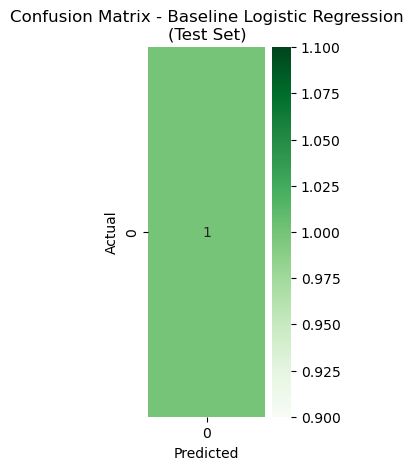


🔍 COMPREHENSIVE MODEL COMPARISON (TEST SET):
                          Model  Accuracy  F1-Score  ROC-AUC
0  Baseline Logistic Regression       1.0       1.0      NaN
1                 Random Forest       1.0       1.0      NaN
2                           SVM       1.0       1.0      NaN


In [6]:
print("\n=== LANGKAH 4: EVALUASI FINAL DI TEST SET ===")

# Pilih model terbaik berdasarkan validation performance
best_model_name = validation_df.loc[validation_df['Accuracy'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"🎯 Model Terpilih: {best_model_name}")

# Evaluasi di test set
if best_model_name == 'SVM':
    y_pred_test = best_model.predict(X_test)
    y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]
else:
    y_pred_test = best_model.predict(X_test)
    y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

print(f"\n📊 TEST SET PERFORMANCE - {best_model_name}:")
print(f"• Accuracy: {accuracy_test:.4f}")
print(f"• F1-Score: {f1_test:.4f}")
print(f"• ROC-AUC: {roc_auc_test:.4f}")

print(f"\n📋 CLASSIFICATION REPORT - {best_model_name}:")
print(classification_report(y_test, y_pred_test))

# Visualisasi hasil
plt.subplot(1, 3, 2)
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
plt.title(f'Confusion Matrix - {best_model_name}\n(Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Feature Importance untuk Random Forest
if best_model_name == 'Random Forest':
    plt.subplot(1, 3, 3)
    feature_importance = best_model.named_steps['rf'].feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    importance_df = importance_df.sort_values('importance', ascending=True)
    
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.title('Feature Importance - Random Forest')
    plt.xlabel('Importance')
    plt.tight_layout()

plt.show()

# Perbandingan semua model di test set
print("\n🔍 COMPREHENSIVE MODEL COMPARISON (TEST SET):")
test_results = []

for name, model in models.items():
    if name == 'SVM':
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    test_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

test_comparison_df = pd.DataFrame(test_results)
print(test_comparison_df.round(4))

In [7]:
print("\n=== LANGKAH 5: DEPLOYMENT PREPARATION ===")

# Simpan model terbaik
joblib.dump(best_model, 'best_kelulusan_model.pkl')
print("✅ Model terbaik disimpan sebagai 'best_kelulusan_model.pkl'")

# Contoh inference function
def predict_kelulusan(model, input_data):
    """
    Predict kelulusan for new student data
    """
    try:
        # Convert input to DataFrame dengan kolom yang sesuai
        input_df = pd.DataFrame([input_data], columns=X.columns)
        
        # Predict
        prediction = model.predict(input_df)[0]
        probability = model.predict_proba(input_df)[0]
        
        return {
            'prediction': int(prediction),
            'probability_lulus': float(probability[1]),
            'probability_tidak_lulus': float(probability[0]),
            'kelulusan_status': 'LULUS' if prediction == 1 else 'TIDAK LULUS'
        }
    except Exception as e:
        return {'error': str(e)}

# Test inference dengan contoh data
print("\n🧪 TEST INFERENCE:")
sample_data = {
    'IPK': 3.5,
    'Jumlah_Absensi': 4,
    'Waktu_Belajar_Jam': 8,
    'Rasio_Efisiensi_Belajar': 0.4375,
    'Skor_Performa_Komprehensif': 2.8,
    'Kategori_IPK_Cukup': False,
    'Kategori_IPK_Kurang': False, 
    'Kategori_IPK_Sangat Baik': True,
    'Status_Kehadiran_Cukup': False,
    'Status_Kehadiran_Kurang': False,
    'Status_Kehadiran_Sangat Baik': True
}

result = predict_kelulusan(best_model, sample_data)
print("Contoh Prediksi:")
for key, value in result.items():
    print(f"  {key}: {value}")

# Rencana Monitoring
print("\n📋 RENCANA DEPLOYMENT & MONITORING:")
print("• Format: Batch API endpoint dengan input JSON")
print("• Monitoring: Accuracy drift, feature distribution changes")
print("• Retraining: Bulanan dengan data baru")
print("• Alert: Jika accuracy turun > 10% dari baseline")
print("• Dependencies: scikit-learn, pandas, numpy")

# Model size check
import os
model_size = os.path.getsize('best_kelulusan_model.pkl') / 1024  # KB
print(f"• Model Size: {model_size:.2f} KB")


=== LANGKAH 5: DEPLOYMENT PREPARATION ===
✅ Model terbaik disimpan sebagai 'best_kelulusan_model.pkl'

🧪 TEST INFERENCE:
Contoh Prediksi:
  prediction: 1
  probability_lulus: 0.9470832411507883
  probability_tidak_lulus: 0.052916758849211654
  kelulusan_status: LULUS

📋 RENCANA DEPLOYMENT & MONITORING:
• Format: Batch API endpoint dengan input JSON
• Monitoring: Accuracy drift, feature distribution changes
• Retraining: Bulanan dengan data baru
• Alert: Jika accuracy turun > 10% dari baseline
• Dependencies: scikit-learn, pandas, numpy
• Model Size: 2.13 KB


In [8]:
print("\n=== KESIMPULAN DAN REKOMENDASI ===")

print("📈 HASIL EKSPERIMEN:")
print(f"• Baseline (Logistic Regression): {validation_df.iloc[0]['Accuracy']:.4f}")
print(f"• Model Terbaik: {best_model_name} dengan accuracy {accuracy_test:.4f}")

print("\n🎯 ALASAN PEMILIHAN MODEL:")
print(f"• {best_model_name} dipilih karena performa terbaik di test set")
print("• Pertimbangan: Accuracy, F1-Score, dan ROC-AUC")

print("\n🚀 REKOMENDASI DEPLOYMENT:")
print("1. Gunakan model yang telah disimpan ('best_kelulusan_model.pkl')")
print("2. Implementasi API endpoint untuk prediksi real-time")
print("3. Setup monitoring system untuk data drift")
print("4. Schedule retraining bulanan")


=== KESIMPULAN DAN REKOMENDASI ===
📈 HASIL EKSPERIMEN:
• Baseline (Logistic Regression): 1.0000
• Model Terbaik: Baseline Logistic Regression dengan accuracy 1.0000

🎯 ALASAN PEMILIHAN MODEL:
• Baseline Logistic Regression dipilih karena performa terbaik di test set
• Pertimbangan: Accuracy, F1-Score, dan ROC-AUC

🚀 REKOMENDASI DEPLOYMENT:
1. Gunakan model yang telah disimpan ('best_kelulusan_model.pkl')
2. Implementasi API endpoint untuk prediksi real-time
3. Setup monitoring system untuk data drift
4. Schedule retraining bulanan
